### Imports

In [1]:
import networkx
import itertools
import dataclasses
import math
import typing
import matplotlib.pyplot as plt
import random
import contexttimer
import heapq
import numpy

from IPython.display import display
import ipywidgets

### Data

In [2]:
class Data:
    """
    Data for graph community detection.
    """
    
    @staticmethod
    def __read_graph(path: str) -> networkx.classes.Graph:
        graph = networkx.read_gml(path, label="id")
        graph = networkx.convert_node_labels_to_integers(graph)
        return graph
    
    @staticmethod
    def __read_weird_graph(path: str) -> networkx.classes.Graph:
        graph = networkx.classes.Graph()
        with open(path) as f:
            for line in f:
                if len(line) >= 1 and line[0] == "#":
                    continue
                
                split = line.split()
                node_from = int(split[0])
                node_to = int(split[1])
                graph.add_edge(node_from, node_to)
        graph = networkx.convert_node_labels_to_integers(graph)
        return graph
    
    @staticmethod
    def __read_answer(path: str) -> numpy.ndarray:
        communities_list = []
        node_count = 0
        with open(path) as f:
            for line in f:
                community_list = []
                for node in line.split():
                    community_list.append(int(node)-1)
                    node_count += 1
                communities_list.append(community_list)
        
        communities = numpy.zeros(node_count)
        for community, community_list in enumerate(communities_list):
            for node in community_list:
                communities[node] = community
        
        return communities
    
    def __init__(
        self,
        graph_path: str,
        *,
        answer_path: typing.Optional[str] = None,
        weird_format: bool = False,
    ):
        if not weird_format:
            self.graph = Data.__read_graph(graph_path)
        else:
            self.graph = Data.__read_weird_graph(graph_path)
        if answer_path is not None:
            self.answer = Data.__read_answer(answer_path)
        else:
            self.answer = None

datas = {
    "karate": Data(
       "./karate/karate.gml",
       answer_path="./karate/real.dat",
    ),
    "football": Data(
        "./football/football.gml",
        answer_path="./football/real.dat",
    ),
    "dolphins": Data(
        "./dolphins/dolphins.gml",
        answer_path="./dolphins/real.dat",
    ),
    "krebs": Data(
        "./krebs/krebs.gml",
        answer_path="./krebs/real.dat",
    ),
    
    # data I found
    # "lesmis": Data(
    #     "./student/lesmis.gml",
    # ),
    # "oa-1": Data(
    #     "./student/oa-1.gml",
    # ),
    # "oa-2": Data(
    #     "./student/oa-2.gml",
    # ),
    # "oa-3": Data(
    #     "./student/oa-3.gml",
    # ),
    # "my-1": Data(
    #     "./student/my-1.gml",
    # ),
    # "my-2": Data(
    #     "./student/my-2.gml",
    # ),
    
    # "cora": Data(
    #     "./student/cora.gml",
    # ),
    
    # extra data
    "ungraph": Data(
        "./extra/com-dblp.ungraph.txt",
        weird_format = True,
    ),
    "lesmis": Data(
        "./extra/lesmis.gml",
    ),
    "netscience": Data(
        "./extra/netscience.gml",
    ),
    "my-1": Data(
        "./extra/my-1.gml",
    ),
}

### Fitness

Fie $C_1$, $C_2$ două comunități și $A_{ij}$ matricea de adiacență.

$$
L(C_1,C_2)=\sum_{i\in C_1,j\in C_2}A_{ij}
$$

#### Modularity

$$
Q=\sum_{i=1}^k\frac{L(C_i,C_i)}{2m}-\left(\frac{L(C_i,V)}{2m}\right)^2
$$

In [3]:
def modularity(
    graph: networkx.classes.Graph,
    communities: numpy.ndarray,
) -> float:
    communities_count = numpy.max(communities) + 1
    
    community_in = numpy.zeros(communities_count)
    community_all = numpy.zeros(communities_count)
    
    for node in graph.nodes():
        community = communities[node]
        for neighbor in graph.neighbors(node):
            if community == communities[neighbor]:
                community_in[community] += 1
            community_all[community] += 1
    
    community_in /= len(graph.edges())*2
    community_all /= len(graph.edges())*2
    
    result = numpy.sum(
        community_in - community_all**2
    )
    return result

#### Modularity density

$$
D=\sum_{i=1}^k\frac{L(C_i,C_i)-L(C_i,\overline{C_i})}{|C_i|}
$$

In [4]:
def modularity_density(
    graph: networkx.classes.Graph,
    communities: numpy.ndarray,
) -> float:
    communities_count = numpy.max(communities) + 1
    
    community_in = numpy.zeros(communities_count)
    community_out = numpy.zeros(communities_count)
    community_node_count = numpy.zeros(communities_count)
    
    for node in graph.nodes():
        community = communities[node]
        community_node_count[community] += 1
        for neighbor in graph.neighbors(node):
            if community == communities[neighbor]:
                community_in[community] += 1
            else:
                community_out[community] += 1
    
    result = numpy.sum(
        numpy.divide(
            community_in - community_out,
            community_node_count,
        )
    )
    
    return result

#### Community score

$$
score(C)=\frac{\sum_{i\in C}\left(\frac{1}{|C|}\sum_{j\in C}A_{ij}\right)^\alpha}{|C|}\times\sum_{i,j\in C}A_{ij}
$$

$$
community\_score=\sum_i^k score(C_i)
$$

In [5]:
def community_score(
    graph: networkx.classes.Graph,
    communities: numpy.ndarray,
    resolution: float,
) -> float:
    communities_count = numpy.max(communities) + 1
    
    community_node_count = numpy.zeros(communities_count)
    for node in graph.nodes():
        community = communities[node]
        community_node_count[community] += 1
    
    community_score_tmp = numpy.zeros(communities_count)
    community_in_degree = numpy.zeros(communities_count)
    for node in graph.nodes():
        community = communities[node]
        
        in_degree = 0
        for node_in in graph.neighbors(node):
            if community == communities[node_in]:
                in_degree += 1
        
        community_in_degree[community] += in_degree
        community_score_tmp[community] += (
            (in_degree / community_node_count[community]) ** resolution
        )
    
    community_score = numpy.multiply(
        numpy.divide(
            community_score_tmp,
            community_node_count,
        ),
        community_in_degree
    )
    
    result = numpy.sum(community_score)
    return result

### Algorithm

Label(value='ungraph')

[0.0, 0.32778740654255695, 0.25403284544349886, 1.0, 0.08072388091704479, 0.35409489268285205, 0.7357471833662088, 0.698287733748802, 0.6890566065917739, 0.5778017523193181]
[1.0, 0.5818947225845449, 0.9924953307426599, 0.620698673724518, 0.0, 0.5812558394459649, 0.6417568842534371, 0.7925368145816027, 0.9931177375254325, 0.4344301088911764]
[0.6909468092469843, 0.0, 0.48226816938643036, 0.39270289950469467, 0.20141161686170148, 0.01706854021293692, 0.41682504288728883, 0.19178324544370473, 0.5015967580665769, 1.0]
[1.0, 1.0, 0.33826407160819894, 0.408681033925213, 0.7497627376957355, 0.0, 0.43114520221781827, 0.7179007201723623, 0.21378529011489542, 0.7983672281809995]
[1.0, 0.260366041655971, 0.0, 0.23555386309877957, 1.0, 0.056698582754834734, 0.5682080183256875, 1.0, 0.6470301279513291, 0.44398472792865834]
[1.0, 1.0, 0.0, 1.0, 0.6287733943446667, 1.0, 1.0, 0.5196614159530109, 1.0, 0.9170263401344572]
[0.6763674645180734, 0.6763674645180734, 0.6763674645180734, 0.6763674645180734, 

Label(value='communities_count = 31148')

KeyboardInterrupt: 

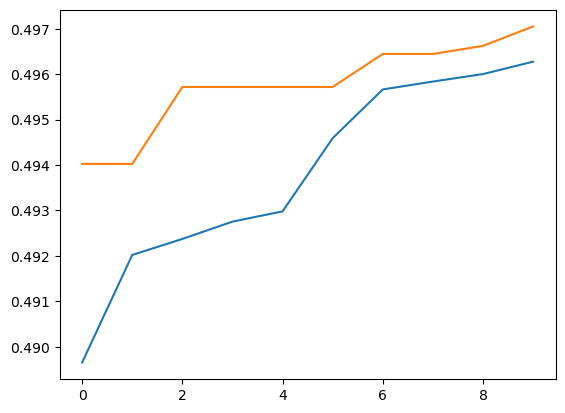

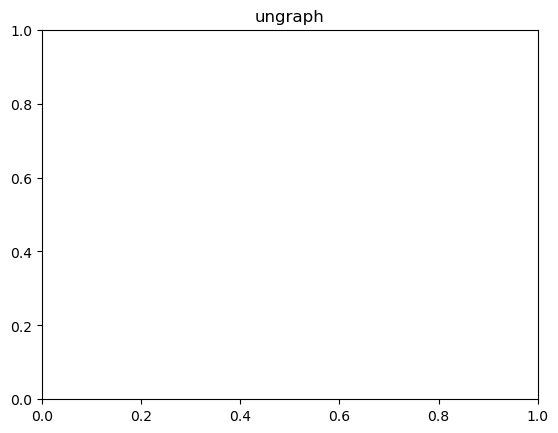

In [6]:
def __get_communities(
    candidate: numpy.array,
    visited: numpy.array,
    communities: numpy.array,
    node: int,
    next_community: int,
) -> int:
    if not visited[node]:
        visited[node] = True
        communities[node] = __get_communities(
            candidate,
            visited,
            communities,
            candidate[node],
            next_community,
        )
    else:
        if communities[node] == 0:
            communities[node] = next_community
    return communities[node]

def get_communities(candidate: numpy.ndarray) -> numpy.ndarray:
    communities = numpy.zeros_like(candidate)
    visited = numpy.zeros_like(candidate)
    next_community = 1
    for node in range(len(candidate)):
        returned_community = __get_communities(
            candidate,
            visited,
            communities,
            node,
            next_community,
        )
        if returned_community >= next_community:
            next_community += 1
    communities -= 1
    return communities

def splice_candidates(
    candidate_1: numpy.ndarray,
    candidate_2: numpy.ndarray,
) -> numpy.ndarray:
    source = numpy.random.rand(len(candidate_1)) > 0.5
    result = numpy.multiply(candidate_1, source) + numpy.multiply(candidate_2, 1-source)
    return result

def random_node_neighbor(graph: networkx.classes.Graph, node: int) -> int:
    if graph.degree(node) == 0:
        return node
    else:
        return random.choice(list(graph.neighbors(node)))

def generate_candidate(graph: networkx.classes.Graph) -> numpy.ndarray:
    # this is certainly slow
    candidate = numpy.zeros(len(graph.nodes()), dtype=int)
    for node in graph.nodes():
        candidate[node] = random_node_neighbor(graph, node)
    return candidate

def community_division_similarity(
    community_1: numpy.ndarray,
    community_2: numpy.ndarray,
) -> float:
    assert len(community_1) == len(community_2)
    
    nodes_count = len(community_1)
    
    graph_similarity = 0
    for node_1 in range(nodes_count):
        for node_2 in range(nodes_count):
            same_1 = community_1[node_1] == community_1[node_2]
            same_2 = community_2[node_1] == community_2[node_2]
            if same_1 == same_2:
                graph_similarity += 1
    graph_similarity /= nodes_count*nodes_count
            
    return graph_similarity

@dataclasses.dataclass(frozen=True, slots=True)
class Candidate:
    value: numpy.ndarray
    fitness: float

def evolve(
    graph: networkx.classes.Graph,
    
    *,
    
    fitness_fn: typing.Callable[[networkx.classes.Graph, numpy.ndarray], float],
    normalize_fitness: bool,
    
    elites_count: int,
    
    generations: int,
    population_len: int,
    mutation_chance: float,
    mutation_len_percent: typing.Optional[float] = None,
    mutation_len_count: typing.Optional[int] = None,
):
    assert (
          (mutation_len_percent is not None)
        + (mutation_len_count is not None)
    ) <= 1
    
    mutation_node_count = None
    if mutation_len_percent is not None:
        mutation_node_count = int(len(new_candidate)*mutation_len_percent)
    elif mutation_len_count is not None:
        mutation_node_count = mutation_len_count
    
    widget_candidates_progress = ipywidgets.IntProgress(min=0, max=population_len)
    widget = ipywidgets.VBox([
        ipywidgets.Label(value="generating candidates..."),
        widget_candidates_progress,
    ])
    display(widget)
    
    candidates = []
    for candidate_index in range(population_len):
        candidates.append(generate_candidate(graph))
        widget_candidates_progress.value = candidate_index+1
    
    best_candidate = None
    
    widget_fitness = ipywidgets.Label()
    widget_progress = ipywidgets.IntProgress(min=0, max=generations-1)
    widget = ipywidgets.VBox([
        ipywidgets.Label(value="evolving..."),
        ipywidgets.HBox([
            ipywidgets.Label(value="fitness = "),
            widget_fitness,
        ]),
        widget_progress,
    ])
    
    display(widget)
    
    hist_average_fitness = []
    hist_best_fitness = []
    
    for generation_index in range(generations):
        widget_progress.value = generation_index
        
        # fitness calculation
        candidates = [
            Candidate(value, fitness_fn(graph, value))
            for value in candidates
        ]
        
        # best candidate
        best_candidate_current = max(candidates, key=lambda candidate: candidate.fitness)
        if best_candidate is None or best_candidate_current.fitness > best_candidate.fitness:
            best_candidate = best_candidate_current
        
        widget_fitness.value = str(best_candidate.fitness)
        
        # hist
        hist_best_fitness.append(best_candidate.fitness)
        hist_average_fitness.append(sum(candidate.fitness for candidate in candidates) / population_len)
        
        # normalization
        fitness_max = max(candidate.fitness for candidate in candidates)
        fitness_min = min(candidate.fitness for candidate in candidates)
        if normalize_fitness:
            candidates = [
                Candidate(
                    candidate.value,
                    (candidate.fitness-fitness_min) / (fitness_max-fitness_min),
                )
                for candidate in candidates
            ]
        
        # new candidates
        new_candidates = []
        
        # elites
        elites = heapq.nlargest(elites_count, candidates, lambda candidate: candidate.fitness)
        new_candidates.extend(candidate.value for candidate in elites)
        
        # splicing
        fitness = [ candidate.fitness for candidate in candidates ]
        print(fitness)        
        while len(new_candidates) < population_len:
            parent_1 = random.choices(candidates, weights=fitness)[0].value
            parent_2 = random.choices(candidates, weights=fitness)[0].value
            new_candidate = splice_candidates(parent_1, parent_2)
            
            # mutation
            if random.random() < mutation_chance:
                for _ in range(mutation_node_count):
                    node = random.randint(0, len(new_candidate)-1)
                    new_candidate[node] = random_node_neighbor(graph, node)
            
            new_candidates.append(new_candidate)
        
        # next generation
        candidates = new_candidates
    
    plt.figure()
    plt.plot(hist_average_fitness)
    plt.plot(hist_best_fitness)
    
    return best_candidate.value

# set results to empty dict, only if it doesn't already exist
try:
    results
except NameError:
    results = {}

for name, data in datas.items():
    if name != "ungraph":
        continue
    # if name != "karate":
    #     continue
                           
    display(ipywidgets.Label(value=name))
    
    # plt.figure()
    # plt.title(name)
    # networkx.draw(data.graph)
    
    # settings
    best_candidate = evolve(
        data.graph,
        
        # fitness_fn = lambda graph, candidate: community_division_similarity(candidate, data.answer),
        fitness_fn = lambda graph, candidate: modularity(graph, get_communities(candidate)),
        # fitness_fn = lambda graph, candidate: modularity_density(graph, get_communities(candidate)),
        # fitness_fn = lambda graph, candidate: community_score(graph, get_communities(candidate), 1.1),
        normalize_fitness = True,
        
        # elites_count = 5,
        # generations = 200,
        # population_len = 200,
        # mutation_len_percent = 0.05,
        
        elites_count = 1,
        generations = 10,
        population_len = 10,
        mutation_len_count = 5,
        
        mutation_chance = 0.2,
    )
    
    communities = get_communities(best_candidate)
    results[name] = communities
    communities_max = numpy.max(communities)+1
    widget = ipywidgets.Label(f"communities_count = {communities_max}")
    display(widget)
    
    if data.answer is not None:
        similarity = community_division_similarity(best_candidate, data.answer)
        widget = ipywidgets.Label(f"similarity = {similarity}")
        display(widget)
    
    plt.figure()
    plt.title(name)
    networkx.draw(data.graph, node_color=communities)
    
    # break

### Show result

#### Small graph

In [ ]:
# name = "netscience"
# plt.figure(figsize=(64,64))
# plt.title(name)
# networkx.draw(datas[name].graph, node_color=results[name])

#### Big graph

In [26]:
import csv

node_size = 1

name = "ungraph"
community = results[name]
graph = datas[name].graph
communities_max = numpy.max(community)

with open("./graph.csv", "w") as f:
    w = csv.writer(f)
    for node_from,node_to in graph.edges():
        w.writerow([
            str(node_from),
            str(node_to),
        ])

used_colors = set()
community_to_color = dict()
with open("./metadata.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(["id", "color", "size"])
    for node in graph.nodes():
        c = community[node]
        while c not in community_to_color:
            color = random.randint(0, 2**24-1)
            if color not in used_colors:
                used_colors.add(color)
                community_to_color[c] = color
        
        w.writerow([
            str(node),
            str(f"#{community_to_color[c]:06x}"),
            str(node_size),
        ])
        
# networkx.drawing.nx_pydot.write_dot(graph, "./graph.dot")